<a id='top'></a>

In [33]:
import warnings
warnings.filterwarnings('ignore')

# Predicting Nightly Mood Scores from Previously Submitted Mood
This notebook explores the affect that the previously reported mood has on the evening/later reported mood.

Some good information can be found [here](https://towardsdatascience.com/comprehensive-guide-to-multiclass-classification-with-sklearn-127cc500f362) on the general process.

In [105]:
import sys
sys.path.append('../')
%load_ext autoreload
%autoreload 2
from src.analysis import mood_prediction
from src.visualization import visualize

import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import matplotlib.dates as mdates

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id='toc'></a>

# Table of Contents
1. [Data Import](#data_import)
2. [Inspection](#inspection)
3. [Classification](#classification)
4. [Prediction](#prediction)
5. [Evaluation](#evaluation)
6. [Saving](#saving)

---

<a id='data_import'></a>

# Data Import
Data are simply imported from the Fitbit daily dataset and Fitbit sleep summary dataset - both of each include data summarized on a daily basis.

In [70]:
data = mood_prediction.ImportProcessing(data_dir="../data/")
data.mood_only.head()

,beiwe,content_e,stress_e,lonely_e,sad_e,energy_e,redcap,date,content_m,stress_m,lonely_m,sad_m,energy_m,tst,sol,naw,restful,discontent_m,discontent_e
0,awa8uces,1.0,1.0,1.0,3.0,2.0,28,2020-05-13,0.0,2.0,1.0,1.0,1.0,2.0,10.0,3.0,1.0,3.0,2.0
1,lkkjddam,0.0,2.0,3.0,1.0,0.0,12,2020-05-13,1.0,1.0,3.0,3.0,2.0,7.0,45.0,2.0,1.0,2.0,3.0
2,rvhdl2la,2.0,1.0,0.0,0.0,1.0,29,2020-05-13,1.0,1.0,2.0,3.0,0.0,5.3,5.0,2.0,2.0,2.0,1.0
3,xxvnhauv,1.0,3.0,1.0,2.0,0.0,21,2020-05-13,1.0,1.0,1.0,3.0,0.0,6.0,30.0,3.0,1.0,2.0,2.0
4,xdbdrk6e,2.0,1.0,2.0,1.0,3.0,23,2020-05-13,2.0,1.0,2.0,1.0,2.0,8.0,20.0,3.0,2.0,1.0,1.0


## Summary

In [71]:
print(f"Number of Datapoints: {len(data.mood_only)}\nNumber of Participants: {len(data.mood_only['beiwe'].unique())}")

Number of Datapoints: 2149
Number of Participants: 62


In [98]:
print(f"Number of Datapoints: {len(data.mood_and_activity)}\nNumber of Participants: {len(data.mood_and_activity['beiwe'].unique())}")

Number of Datapoints: 1201
Number of Participants: 51


---

<a id='inspection'></a>

# Inspection
Doing some higher-level inspection of the data.

## Score Distribution
To aid in binarizing the data more appropriately.

In [38]:
def get_mood_distribution(df_in,moods=["content","stress","lonely","sad","energy"],plot=False):
    """
    Parameters
    ----------
    df_in : DataFrame
        Original data with columns corresponding to the provided moods
    moods : list-like, default ["content","stress","lonely","sad","energy"]
        Strings of the moods to consider - must be columns in df_in
    plot : boolean
        whether or not to output the histograms of the scores
        
    Returns
    -------
    df : DataFrame
        
    """
    res = {mood: [] for mood in moods}
    df = df_in.copy()
    for timing in ["_m","_e"]:
        for mood in moods:
            df[f"{mood}{timing}"] = pd.to_numeric(df[f"{mood}{timing}"])
    if plot:
        _, axes = plt.subplots(2,len(moods),figsize=(len(moods)*4,6),sharey="row",sharex="col")
        for r, timing, label in zip(range(2),["_m","_e"],["Morning (Features)","Evening (Targets)"]):
            for mood, ax in zip(moods,axes[r,:]):
                dist = df[f"{mood}{timing}"].value_counts()
                ax.bar(dist.index,dist.values/dist.sum(),edgecolor="black",color="lightgray")
                for score, height in zip(dist.index,dist.values/dist.sum()):
                    ax.text(score,height+0.05,round(height*100,1),ha="center")
                ax.set_ylim([0,1])
            
                if r == 1:
                    ax.set_xlabel(mood.title(),fontsize=12)
                    
                # appending results to output
                res[mood].append(dist.values)
                                 
            axes[r,0].set_ylabel(label)
            
        plt.show()
        plt.close()
        
    return pd.DataFrame(data=res)

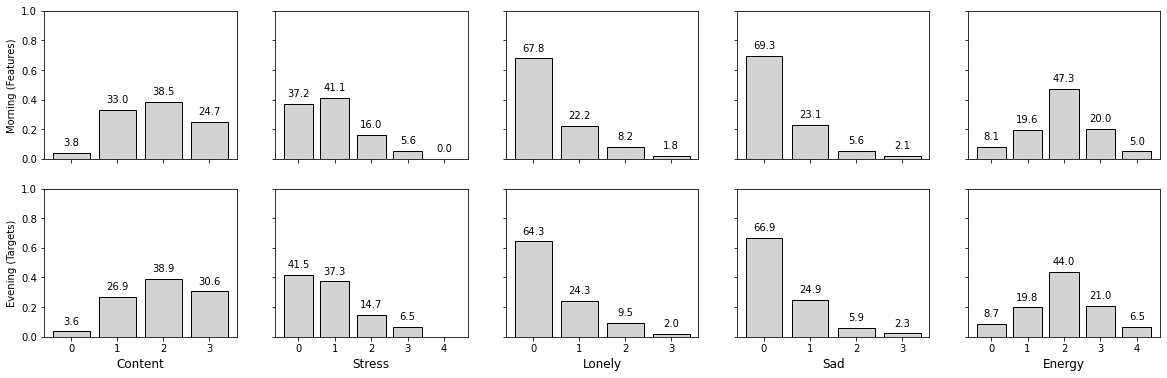

In [72]:
_  = get_mood_distribution(data.mood_only,plot=True)

## Difference in Scores (Evening - Morning)
The simplest way to understand the difference in mood scores is to simply subtract them from one another. The more identical the scores, the greater the instance of zero.

### Aggregate
Just looking at the responses from everyone.

In [75]:
def get_mood_difference(df_in,moods=["discontent","stress","lonely","sad","energy"],plot=False,save=False):
    """
    Calculates the score difference between mood scores ofthe same name.
    
    Parameters
    ----------
    df_in : DataFrame
        Original data with columns corresponding to the provided moods
    moods : list-like, default ["content","stress","lonely","sad","energy"]
        Strings of the moods to consider - must be columns in df_in
    plot : boolean
        whether or not to output the histograms of the differences for each
        mood
    save : boolean
        whether or not to save the figure - plot must also be True
        
    Returns
    -------
    df : DataFrame
        Original dataset with the mood scores removed and replaced with the 
        differences
    """
    df = df_in.copy()
    for mood in moods:
        df[f"{mood}_diff"] = pd.to_numeric(df[f"{mood}_e"]) - pd.to_numeric(df[f"{mood}_m"])
        
    df.drop([col for col in df.columns if col[-2:] in ["_e","_m"]],axis="columns",inplace=True)
    
    if plot:
        _, axes = plt.subplots(1,len(moods),figsize=(len(moods)*4,3),sharey=True,gridspec_kw={"wspace":0})
        for i, (mood, ax) in enumerate(zip(moods,axes)):
            temp = pd.DataFrame(data=df[f"{mood}_diff"].value_counts())
            temp["percent"] = temp[f"{mood}_diff"] / temp[f"{mood}_diff"].sum()
            temp.sort_index(ascending=False,inplace=True)
            rects = ax.bar(temp.index,temp["percent"],width=0.85,edgecolor="black",color="lightgray")
            # x-axis
            if i == 4:
                ax.set_xlim([-4.5,4.5])
                ax.set_xticks(np.arange(-4,5,1))
            else:
                ax.set_xlim([-3.5,3.5])
                ax.set_xticks(np.arange(-3,4,1))
            if i == 2:
                ax.set_xlabel("Score Difference (Evening - Morning)",fontsize=16)
            # y-axis
            ax.set_ylim([0,1])
            ax.tick_params(labelsize=16)
            # remainder
            ax.set_title(mood.title(),pad=-2,fontsize=18)
            for score, height in zip(temp.index,temp["percent"]):
                ax.text(score,height+0.05,round(height*100,1),ha="center",fontsize=12)
            for loc in ["top","right"]:
                ax.spines[loc].set_visible(False)
            
            
        axes[0].set_ylabel("Percent",fontsize=16)
        if save:
            plt.savefig("../reports/figures/ema_summary/beiwe-morning_evening_mood_diff-hist-ux_s20.pdf",bbox_inches="tight")
        plt.show()
        plt.close()
        
        
    return df

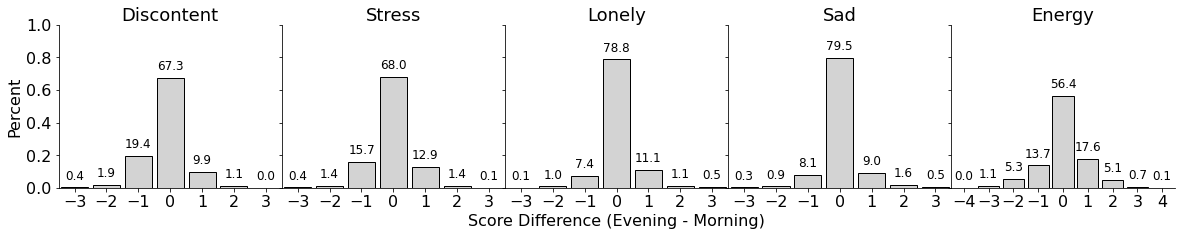

In [77]:
mood_diff = get_mood_difference(data.mood_only,plot=True,save=True)

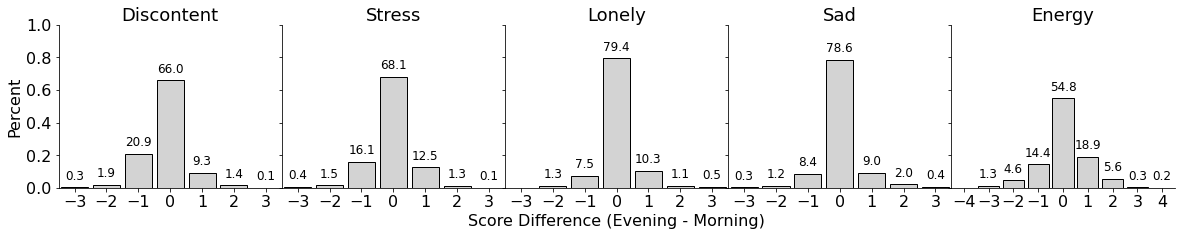

In [99]:
mood_diff = get_mood_difference(data.mood_and_activity,plot=True,save=True)

<div class="alert alert-block alert-info">
    
As expected, many of the differences between the mood scores are zero. This finding is less apparent when considering `energy` which makes sense since the energy of the participants should change. However, I would expect this change to be skewed towards a positive difference (indicating participants were _more_ tired in the evening) but that is not the case. Although they could have low energy in the mornings when they initially wake up. 
    
</div>

<div class="alert alert-block alert-info">
    
The maximum percentages also highlight a sort of upper bound on the accuracy of the model. Just like with our previous analysis, the model might be biased to simply report the same mood score since that is the most influential factor it seems.
    
</div>

### Individual Basis
Participants with a low number of responses might be skewing the data

#### Responses
Before looking at the distributions from each participants' responses, we should actually see how many repsonses they submitted.

In [42]:
def get_response_n(df_in,moods=["content","stress","lonely","sad","energy"],timing="e",plot=False):
    """
    Gets the number of responses from each individual for each provided mood
    
    Parameters
    ----------
    df_in : DataFrame
        Original data with columns corresponding to the provided moods
    moods : list-like, default ["content","stress","lonely","sad","energy"]
        Strings of the moods to consider - must be columns in df_in
    timing : {"e","m"}, default "e"
        specifies whether to consider evening ("e") or morning ("m") EMAs
    plot : boolean
        whether or not to output the histograms of the differences for each
        mood
        
    Returns
    -------
    responses : DataFrame
        DataFrame indexed by participant with columns corresponding to the number
        of responses for the provided moods
    """
    df = df_in.copy()
    responses = {key: [] for key in ["beiwe"] + moods}
    for pt in df["beiwe"].unique():
        responses["beiwe"].append(pt)
        df_pt = df[df["beiwe"] == pt]
        for mood in moods:
            responses[mood].append(len(df_pt[f"{mood}_{timing}"].dropna()))
            
    responses = pd.DataFrame(data=responses)
    if plot:
        _, axes = plt.subplots(len(moods),1,figsize=(22,len(moods)*3),sharex=True,gridspec_kw={"hspace":0.1})
        for mood, ax in zip(moods, axes):
            responses.sort_values(mood,inplace=True)
            ax.scatter(responses["beiwe"],responses[mood],color="black")
            ax.set_title(mood,fontsize=16,pad=0)
            ax.set_ylim([0,70])
            for loc in ["top","right"]:
                ax.spines[loc].set_visible(False)
            
        ax.set_xticklabels(responses["beiwe"].unique(),rotation=-30,ha="left")
        plt.show()
        plt.close()
        
    return responses

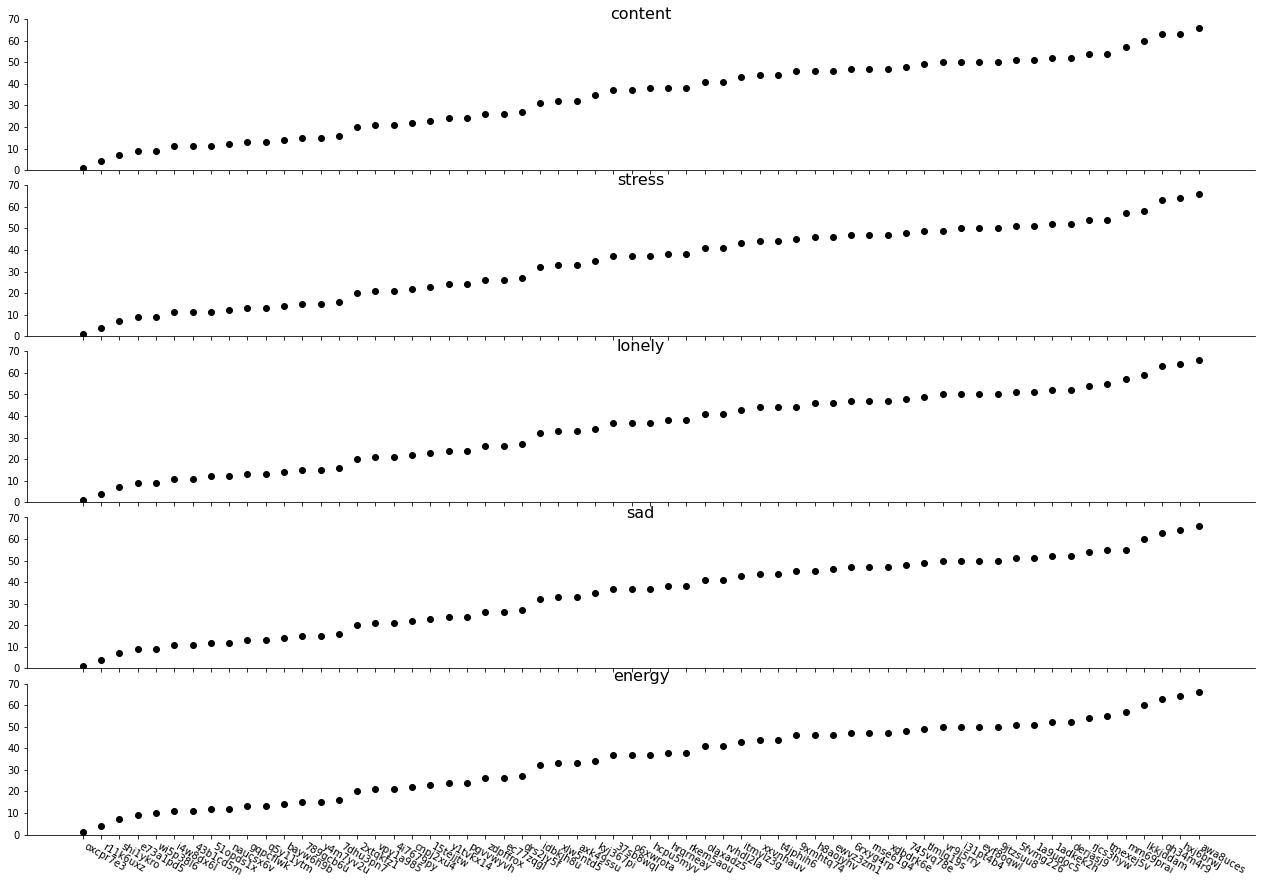

In [78]:
responses_e = get_response_n(data.mood_only,plot=True)

### Inspecting Responses
Now that we know the number of responses, we can see the distribution of how participants rated their moods.

oxcpr7e3


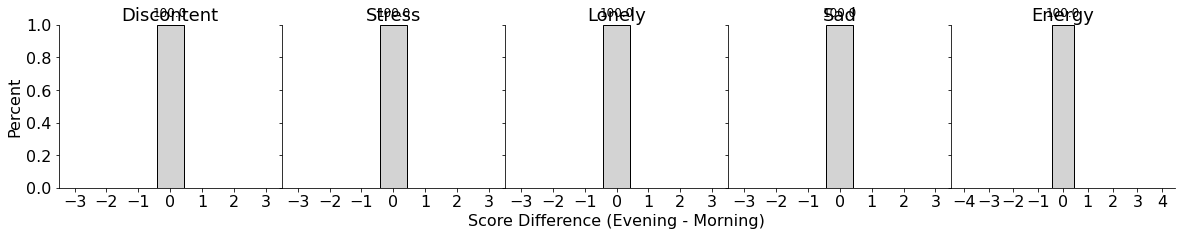

r11k6uxz


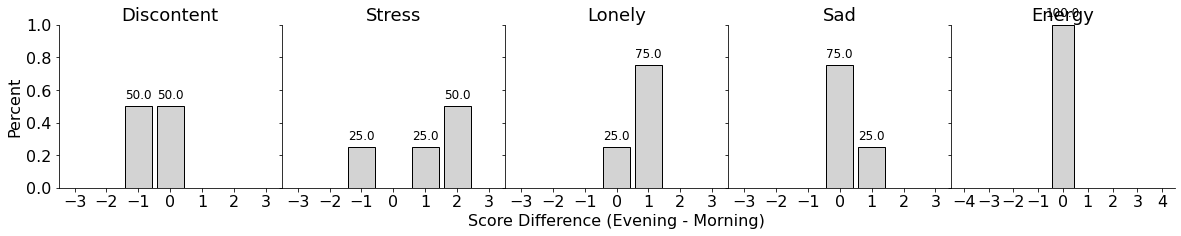

shi1ykro


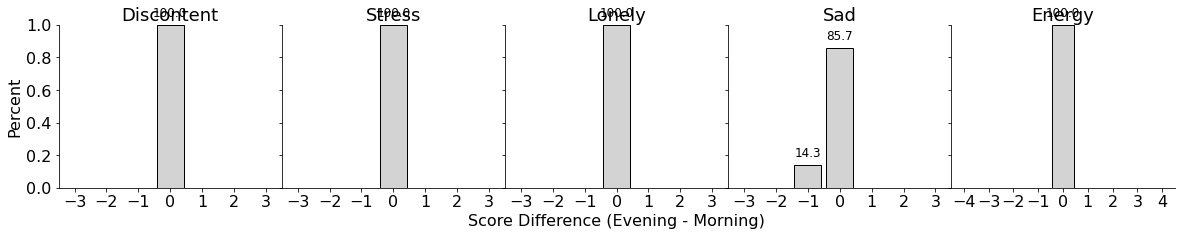

e73a1pd5


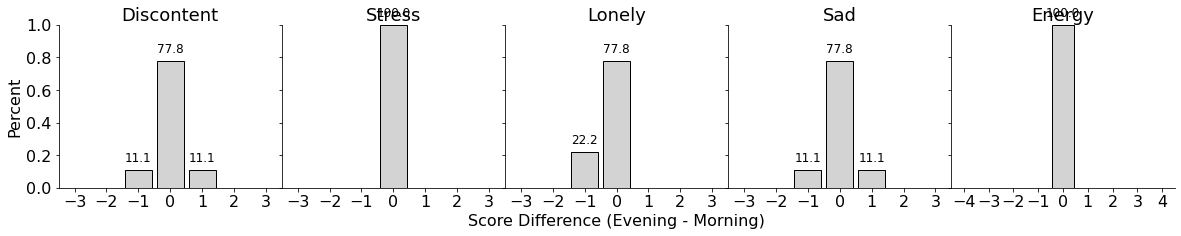

wi5p38l6


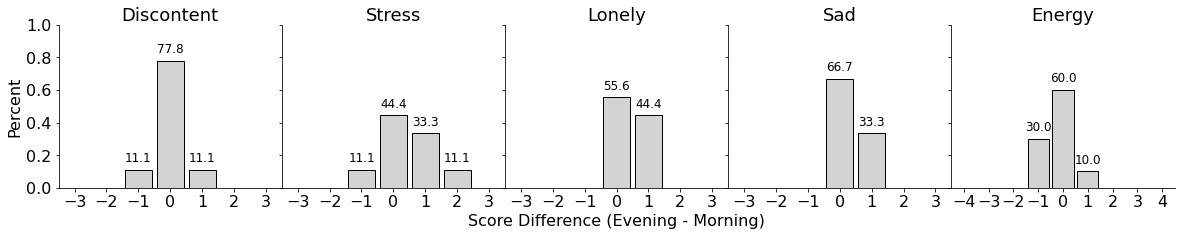

43b1cd5m


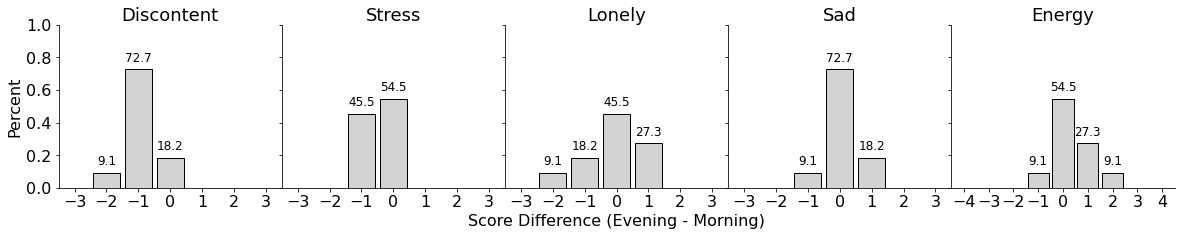

i4w8dx6l


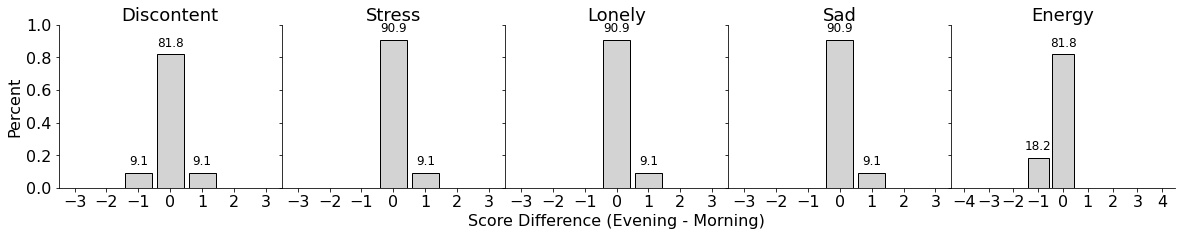

51opds1x


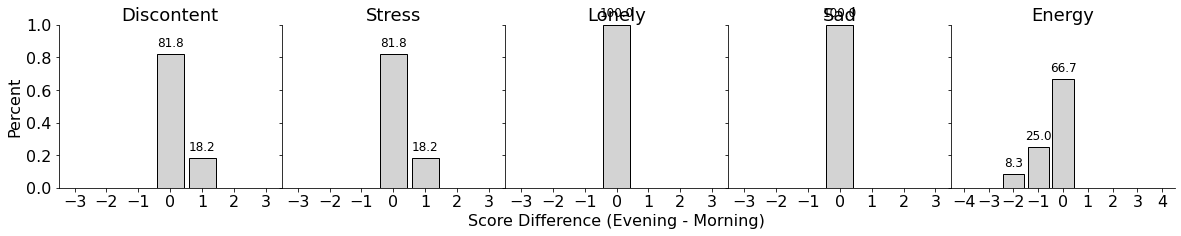

naucsx6v


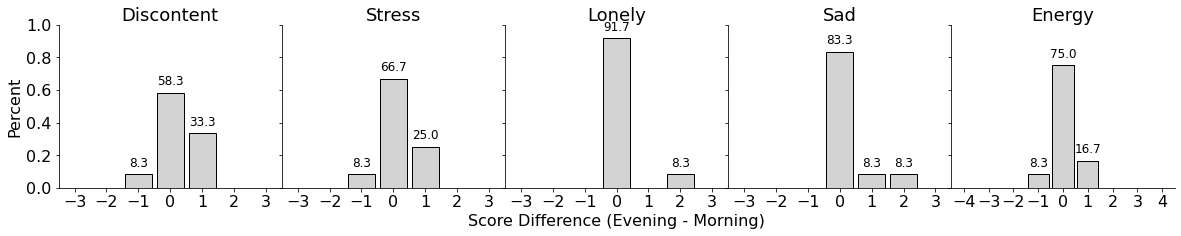

gqpcflwk


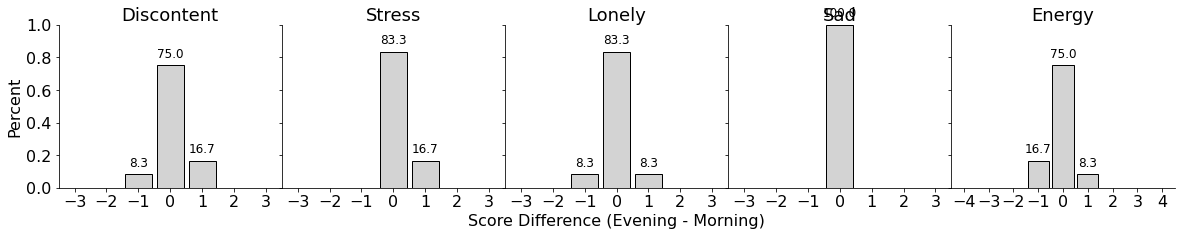

q5y11ytm


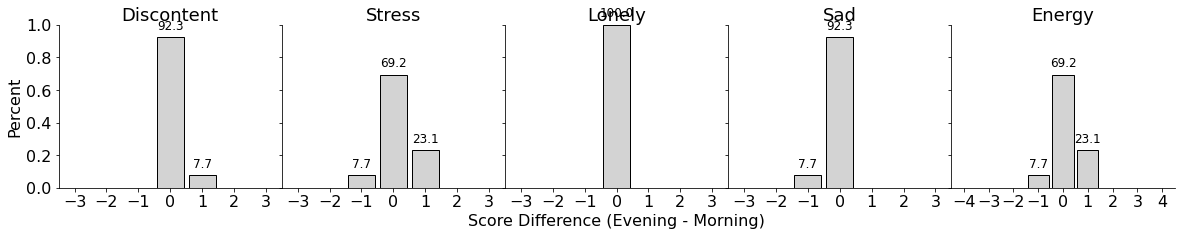

bayw6h9b


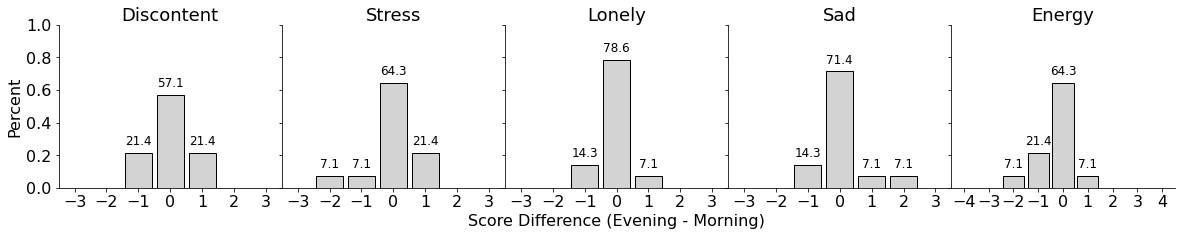

y4m7yv2u


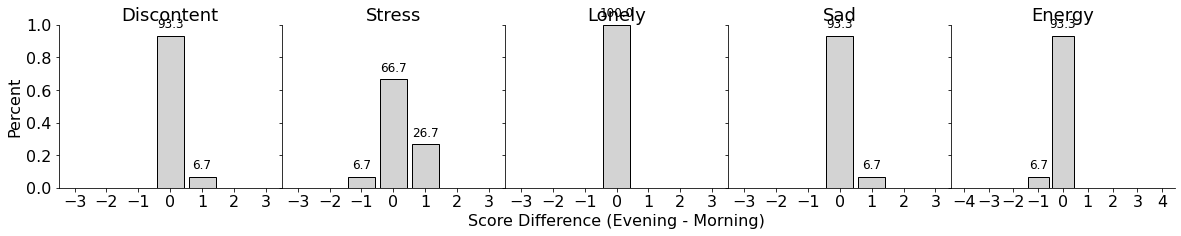

789gcb6u


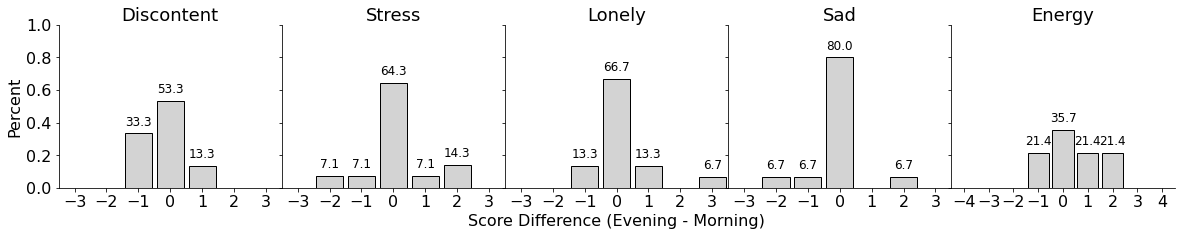

7dhu3pn7


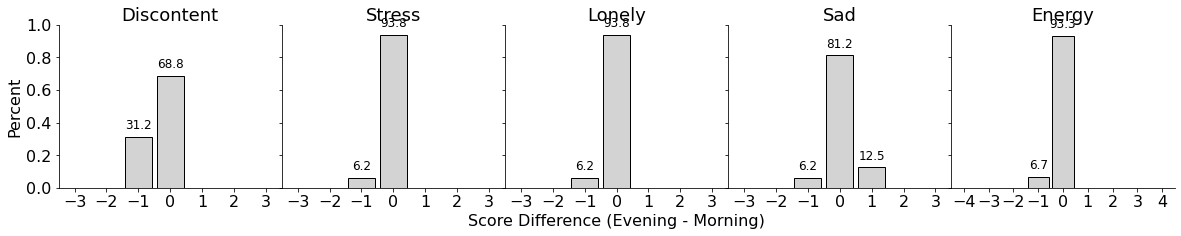

2xtqkfz1


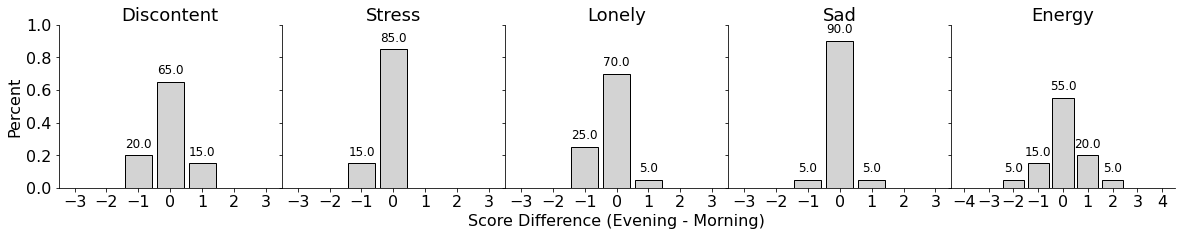

4i7679py


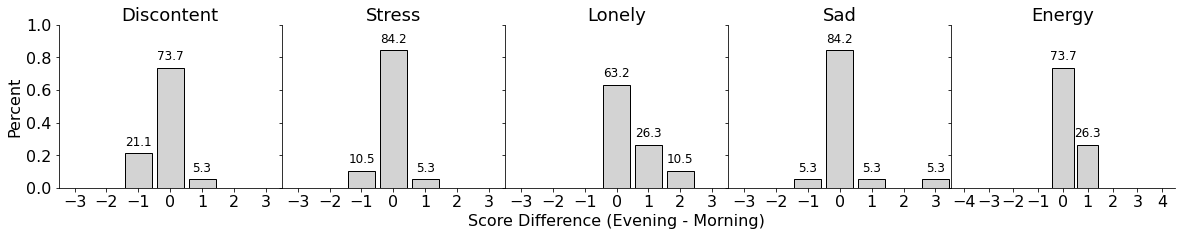

vpy1a985


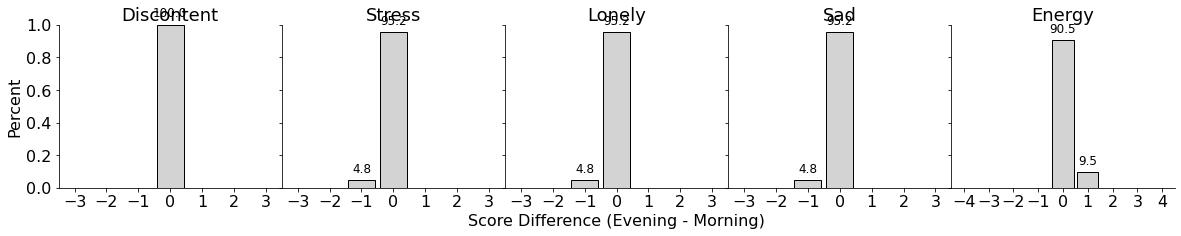

cnpj2xu4


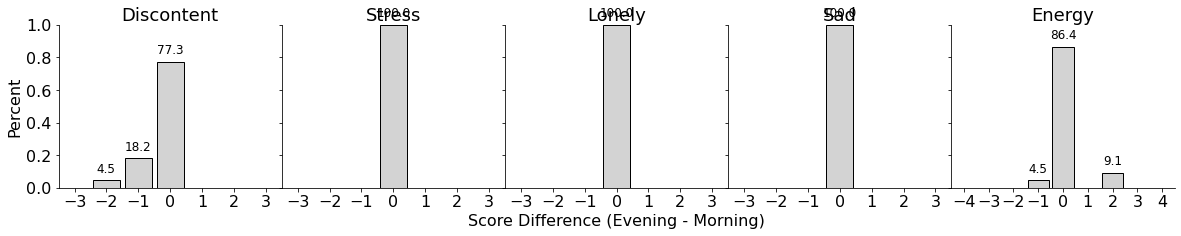

15tejjtw


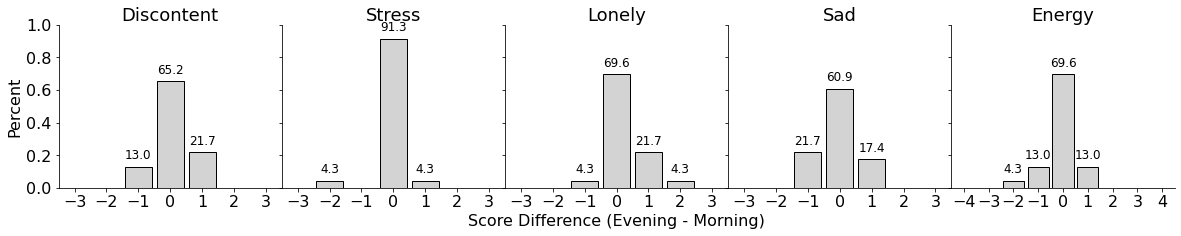

y1tvkx14


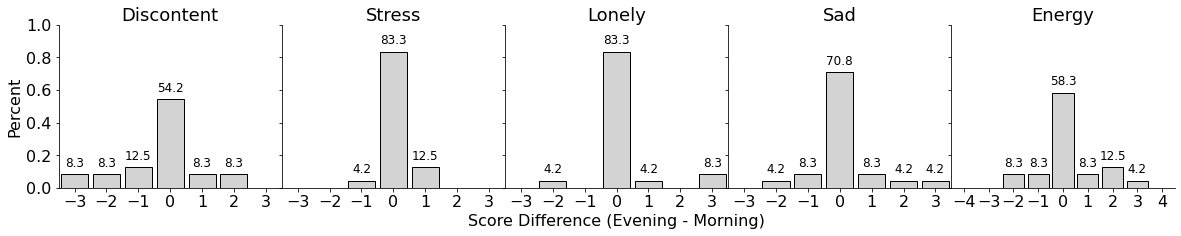

pgvvwyvh


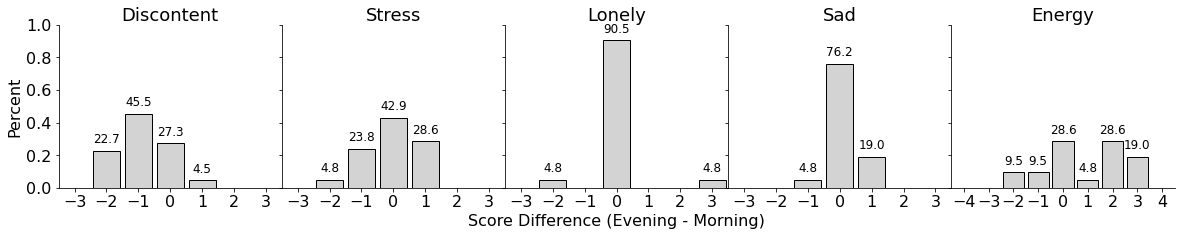

zdpffrox


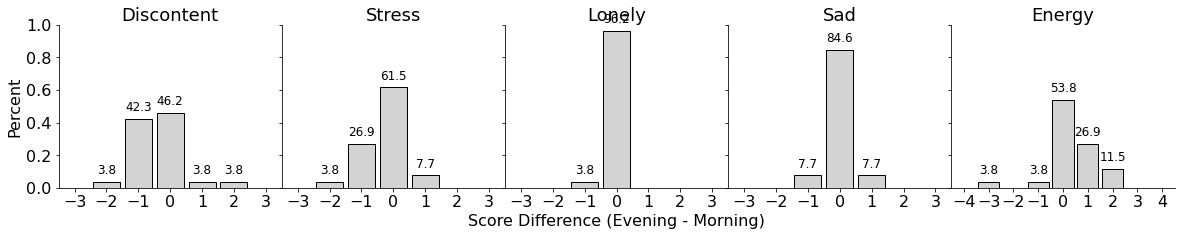

ec77zqgl


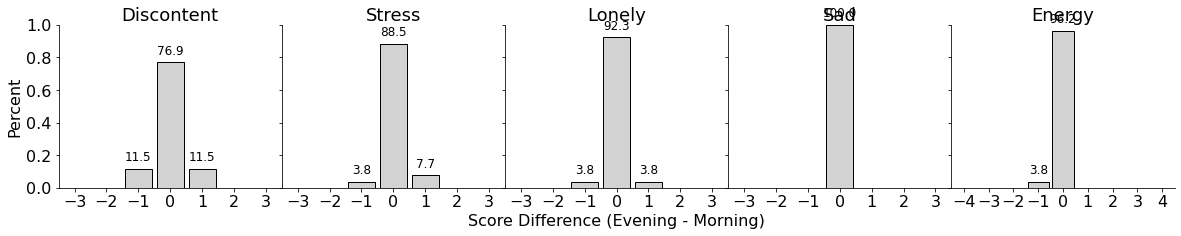

drs2jy5f


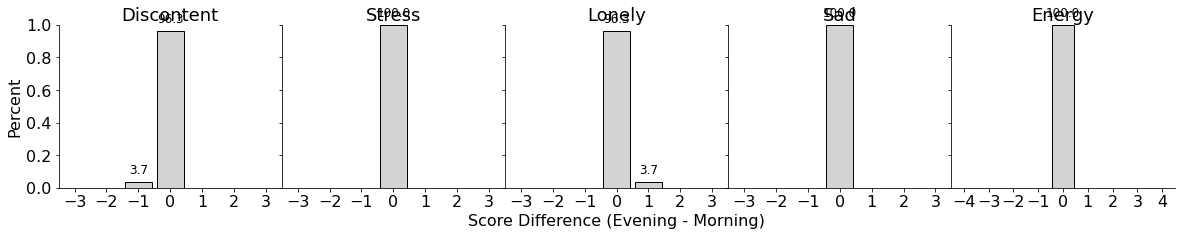

idbkjh8u


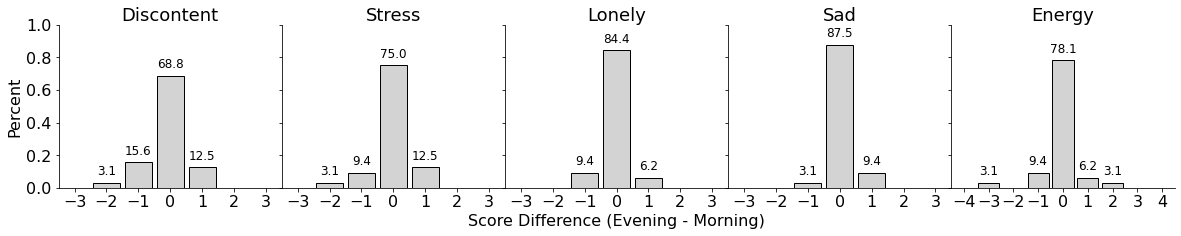

xlw5ntd5


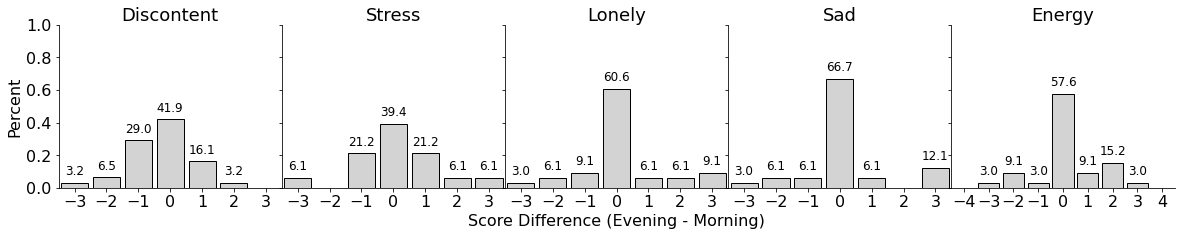

axk49ssu


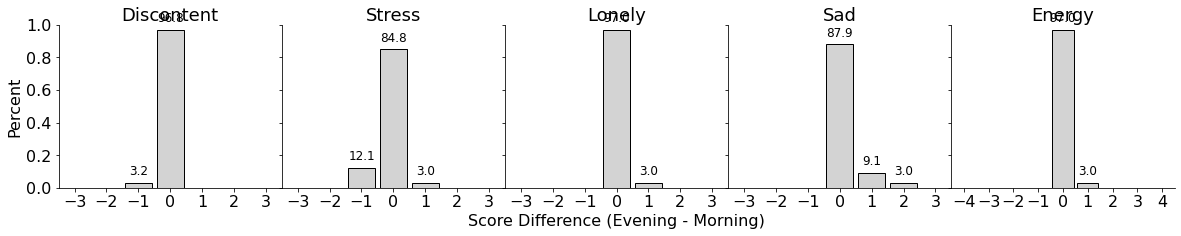

kyj367pi


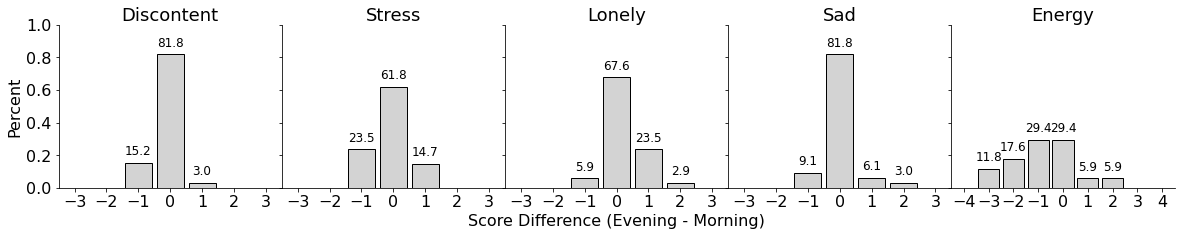

37sb8wql


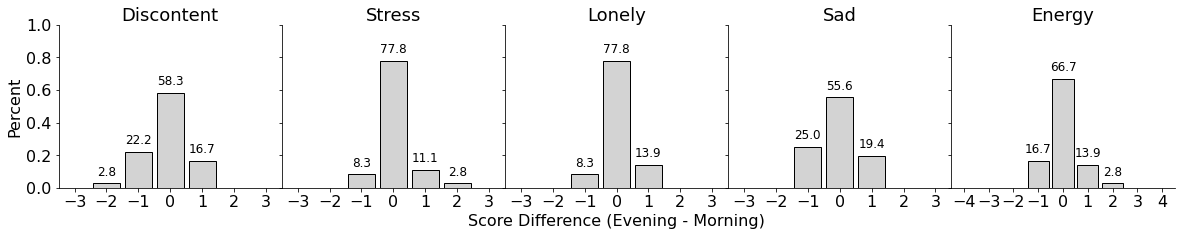

o6xwrota


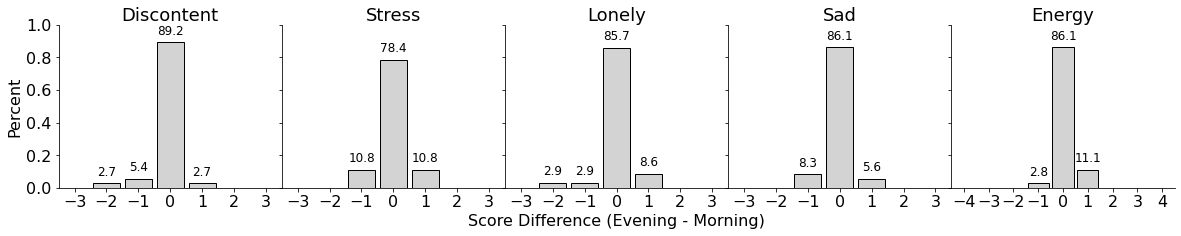

hcpu5myv


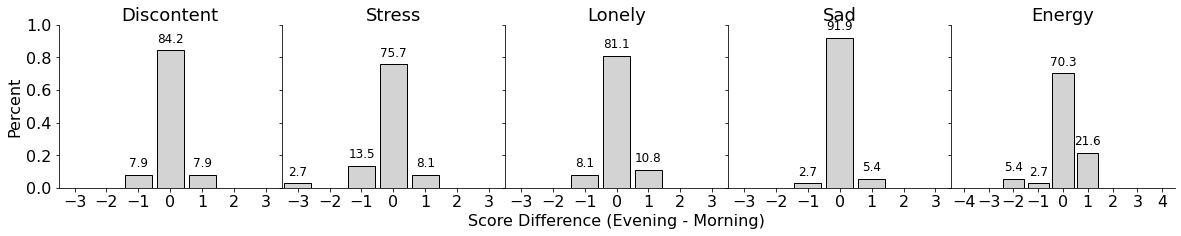

hrqrneay


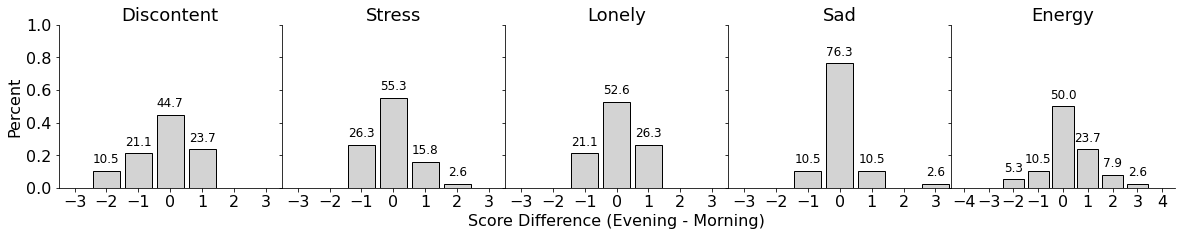

rkem5aou


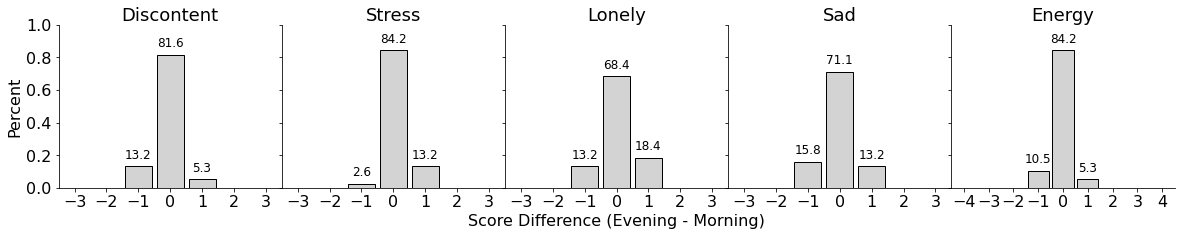

rvhdl2la


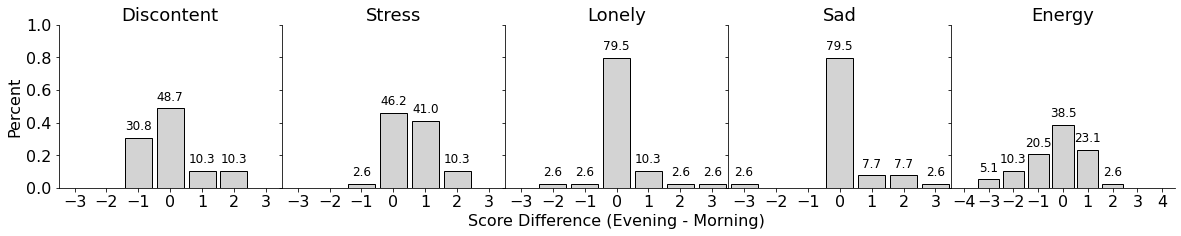

olaxadz5


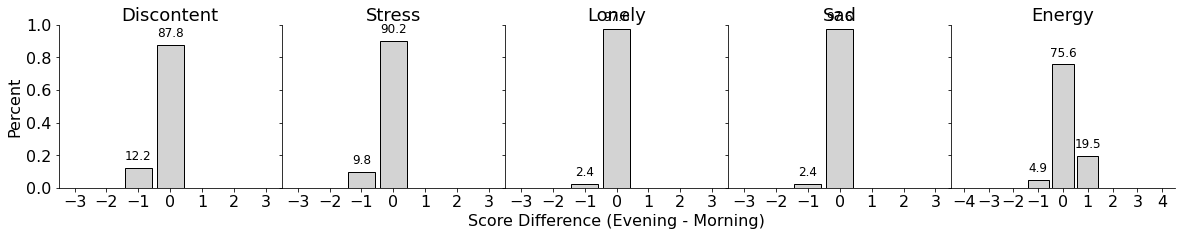

itmylz3g


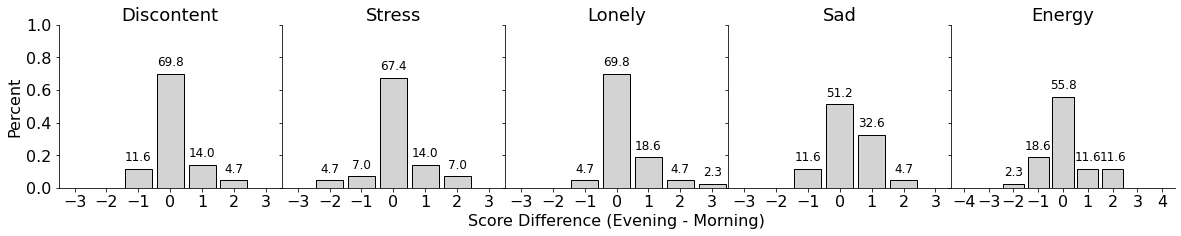

t4jphih6


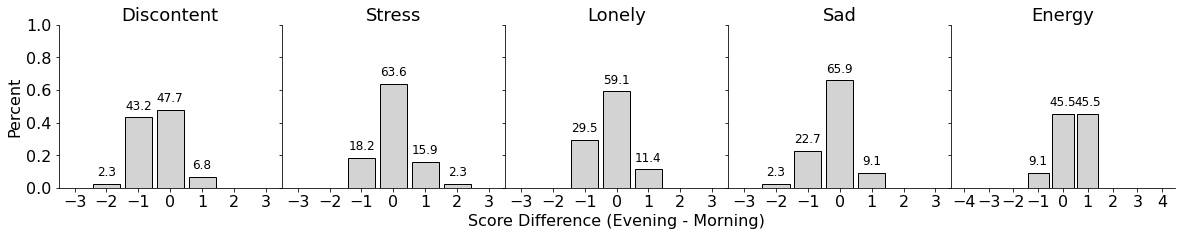

xxvnhauv


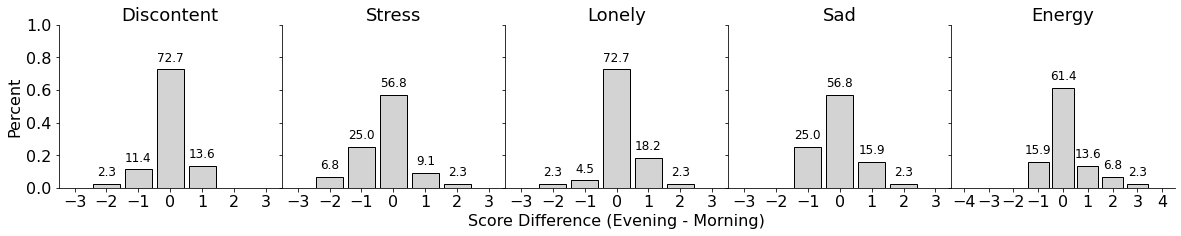

9xmhtq74


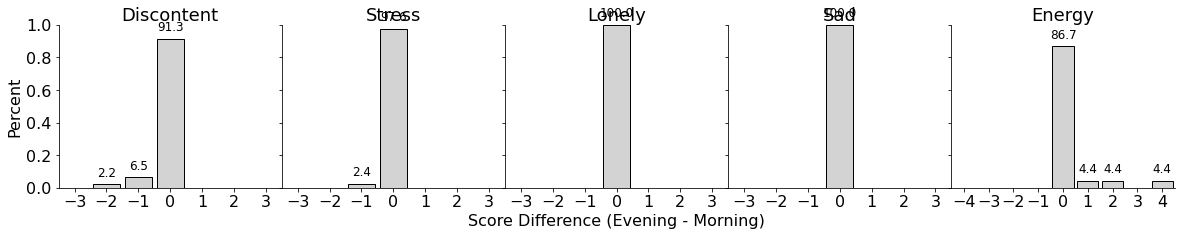

h8aoiyhv


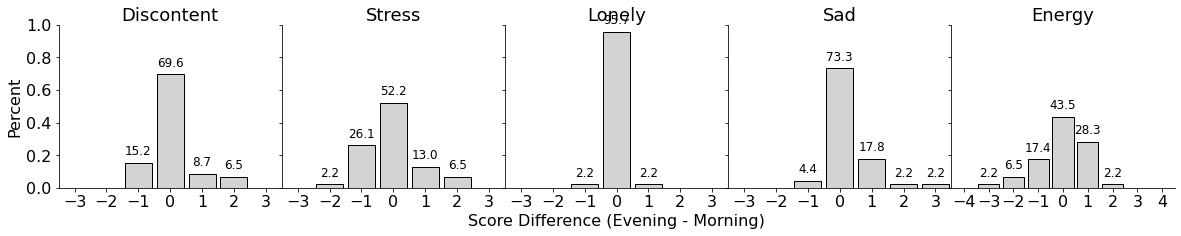

ewvz3zm1


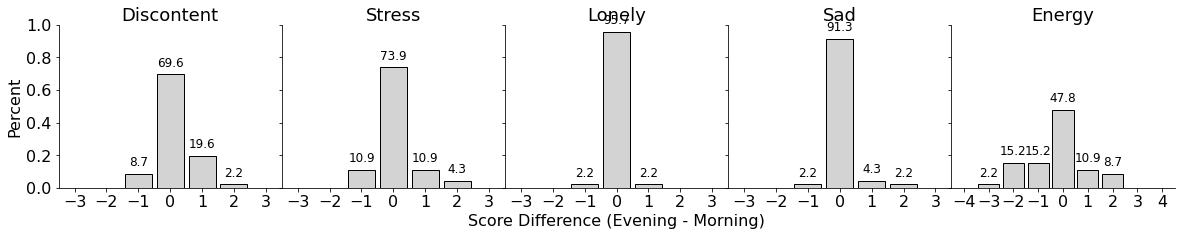

6rxyg4rp


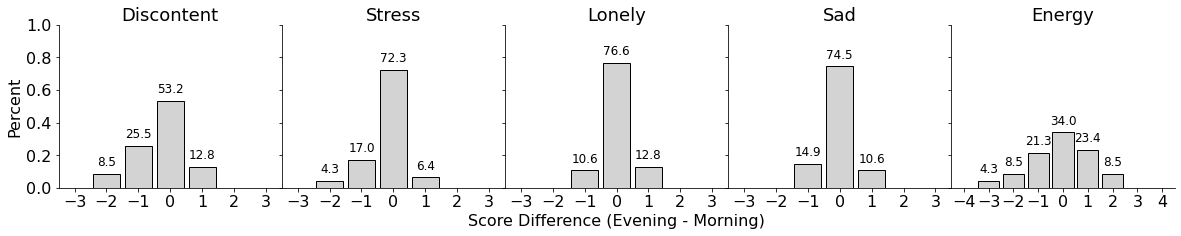

rnse61g4


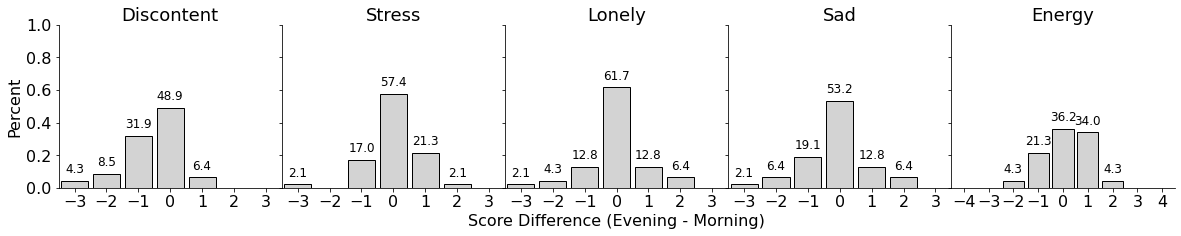

xdbdrk6e


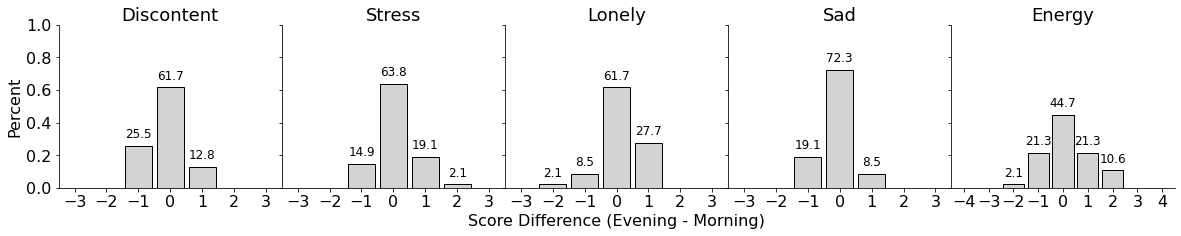

745vq78e


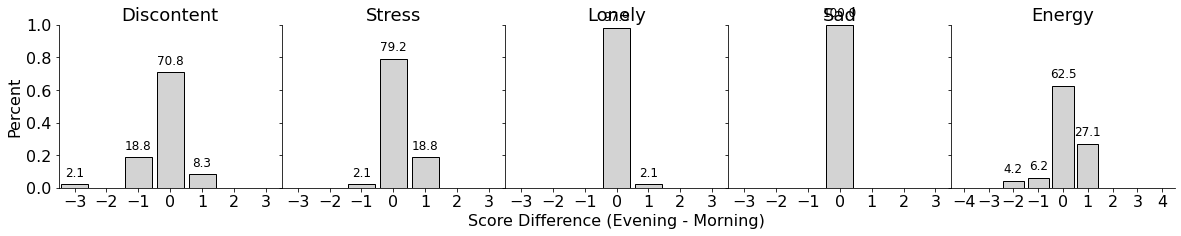

tlmlq19s


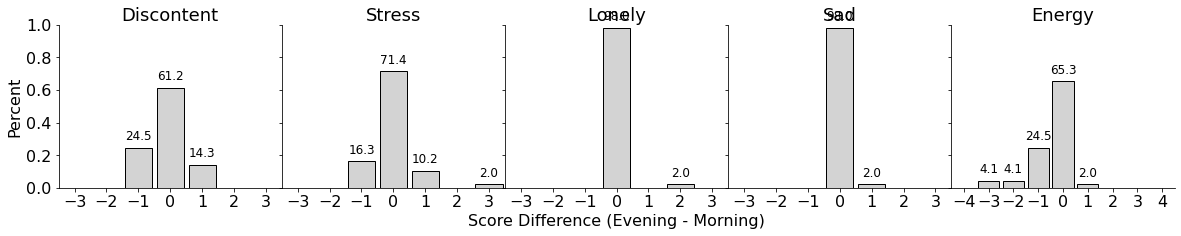

eyf8oqwl


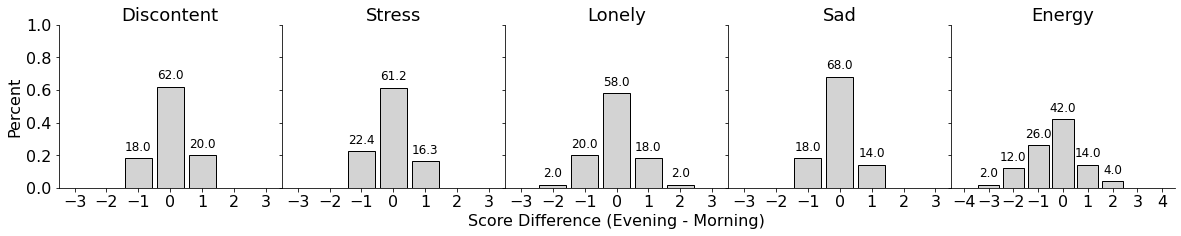

9jtzsuu8


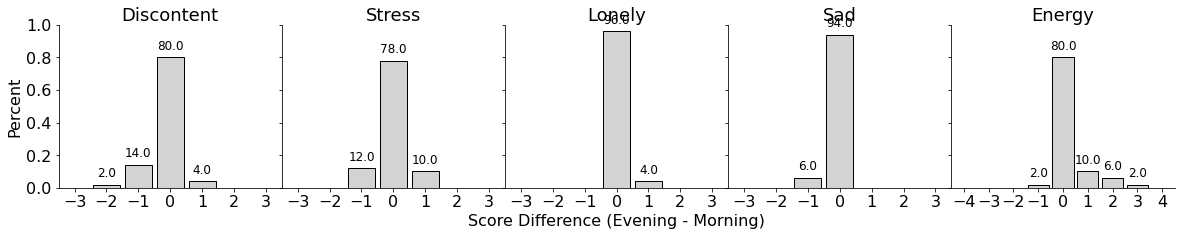

i31pt4b4


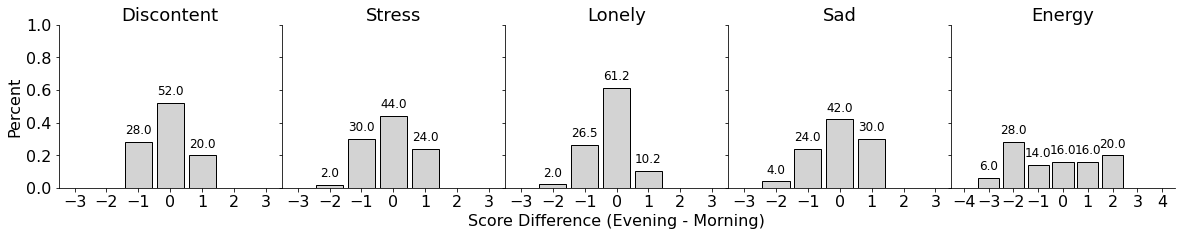

vr9j5rry


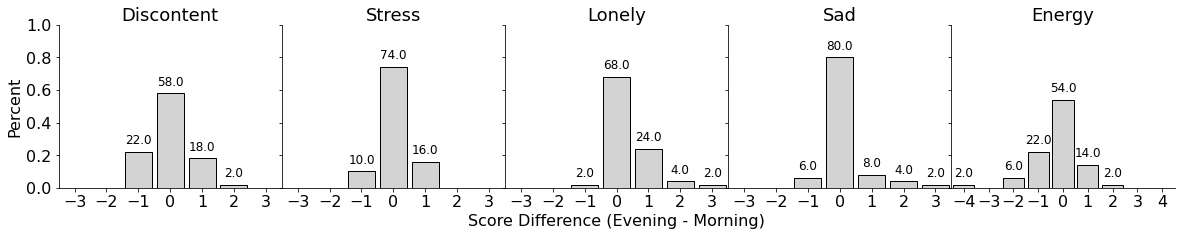

5fvmg226


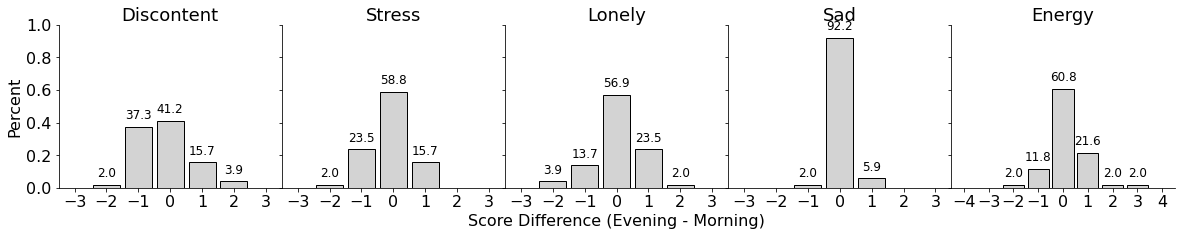

1a9udoc5


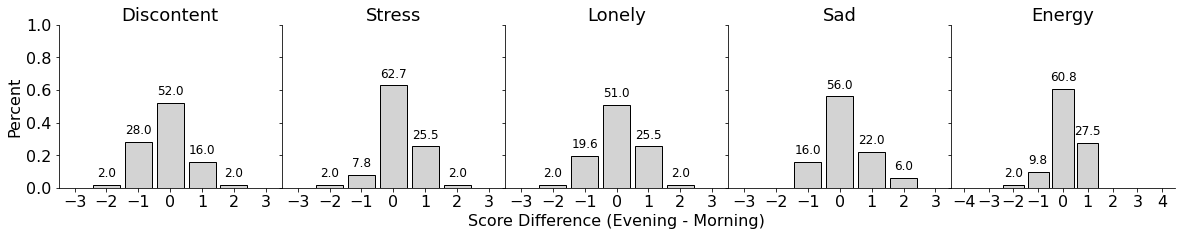

1adkek2h


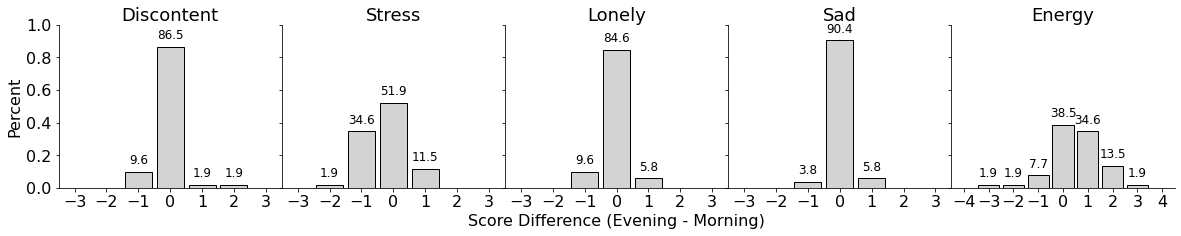

derjasj9


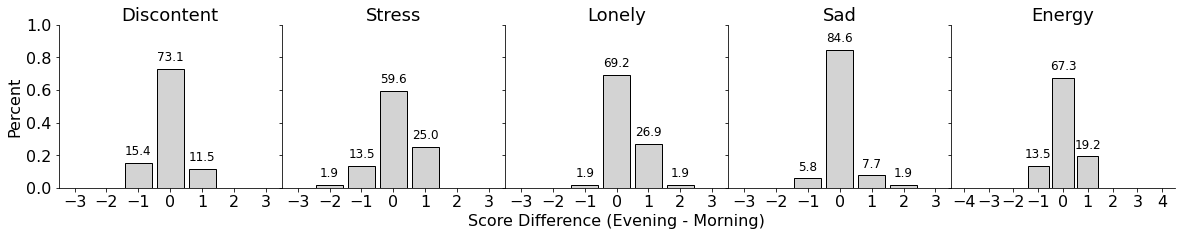

rjcs3hyw


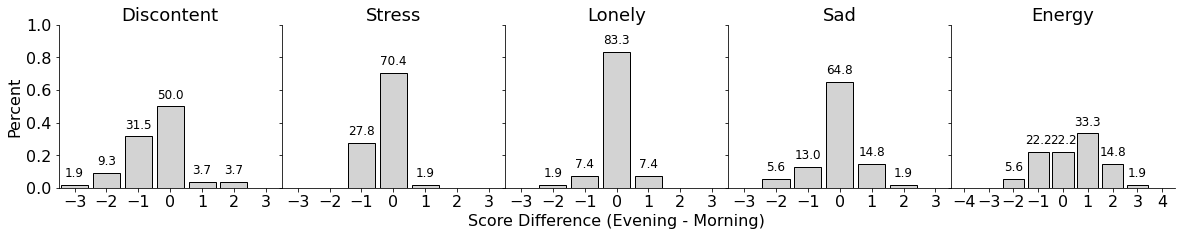

tmexej5v


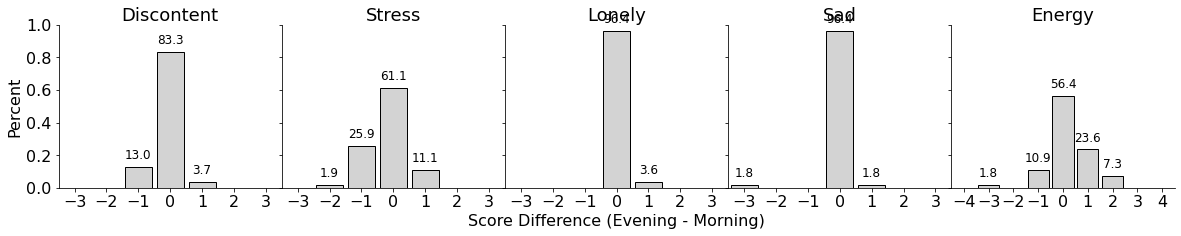

mm69prai


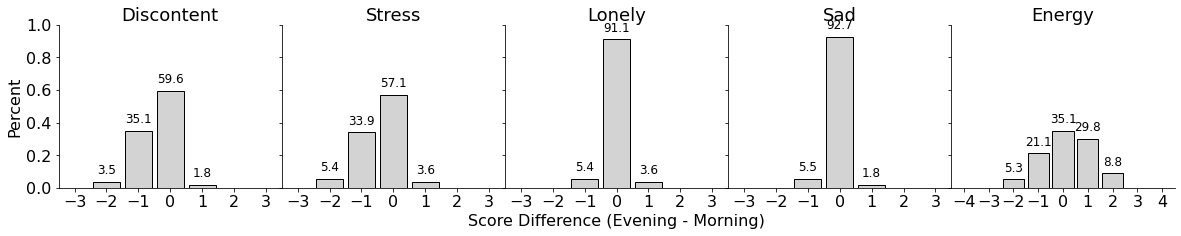

lkkjddam


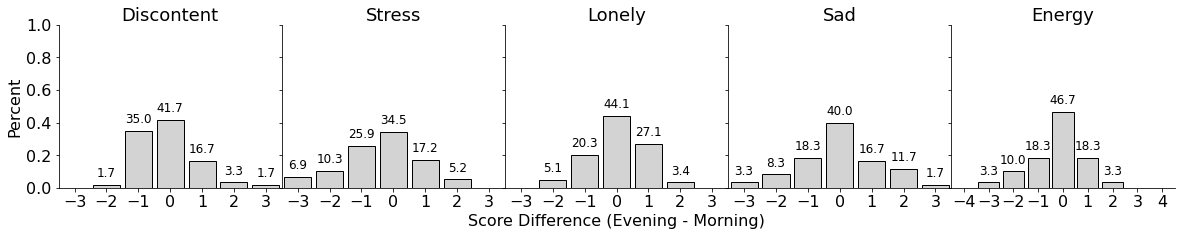

qh34m4r9


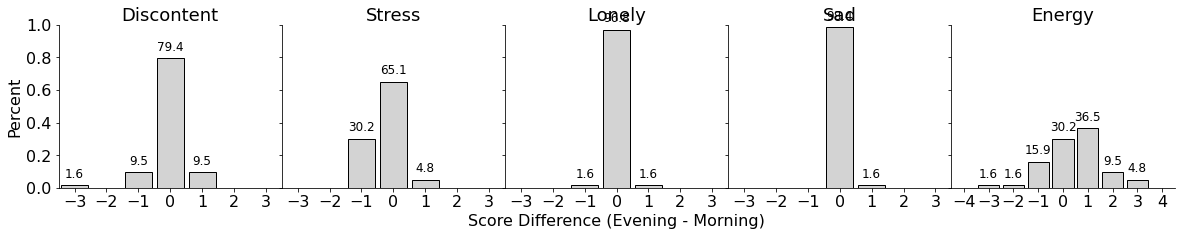

hxj6brwj


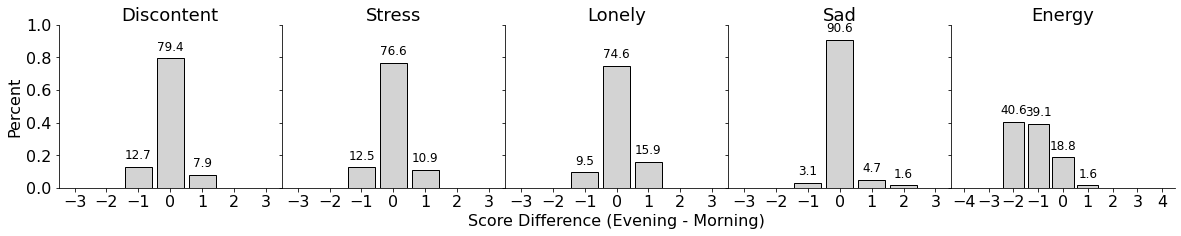

awa8uces


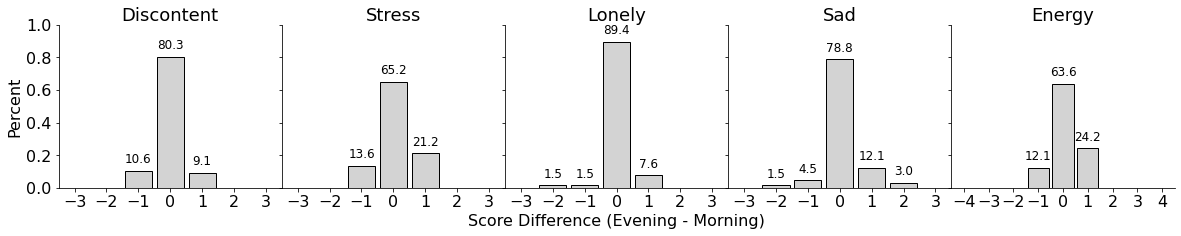

In [79]:
data_with_responses = data.mood_only.merge(responses_e,on="beiwe")
data_with_responses["n"] = data_with_responses[["content","stress","lonely","sad","energy"]].mean(axis=1)
data_with_responses.sort_values("n",inplace=True)
for pt in data_with_responses["beiwe"].unique():
    print(pt)
    _ = get_mood_difference(data_with_responses[data_with_responses["beiwe"] == pt],plot=True)

<div class="alert alert-block alert-info">
    
Despite the varying levels of responses, I don't feel that the participants with only a few responses really responded _significantly_ different than those that responded more often. 
    
We should remove the participant with only one response though...
    
</div>

In [80]:
data.remove_participant(data.mood_only,"oxcpr7e3")

,beiwe,content_e,stress_e,lonely_e,sad_e,energy_e,redcap,date,content_m,stress_m,lonely_m,sad_m,energy_m,tst,sol,naw,restful,discontent_m,discontent_e
0,awa8uces,1.0,1.0,1.0,3.0,2.0,28,2020-05-13,0.0,2.0,1.0,1.0,1.0,2.0,10.0,3.0,1.0,3.0,2.0
1,lkkjddam,0.0,2.0,3.0,1.0,0.0,12,2020-05-13,1.0,1.0,3.0,3.0,2.0,7.0,45.0,2.0,1.0,2.0,3.0
2,rvhdl2la,2.0,1.0,0.0,0.0,1.0,29,2020-05-13,1.0,1.0,2.0,3.0,0.0,5.3,5.0,2.0,2.0,2.0,1.0
3,xxvnhauv,1.0,3.0,1.0,2.0,0.0,21,2020-05-13,1.0,1.0,1.0,3.0,0.0,6.0,30.0,3.0,1.0,2.0,2.0
4,xdbdrk6e,2.0,1.0,2.0,1.0,3.0,23,2020-05-13,2.0,1.0,2.0,1.0,2.0,8.0,20.0,3.0,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2144,2xtqkfz1,3.0,1.0,1.0,1.0,2.0,70,2020-09-01,2.0,1.0,2.0,1.0,1.0,7.0,0.0,0.0,2.0,1.0,0.0
2145,745vq78e,3.0,0.0,0.0,0.0,2.0,55,2020-09-01,3.0,0.0,0.0,0.0,2.0,7.6,0.0,1.0,2.0,0.0,0.0
2146,rkem5aou,2.0,1.0,2.0,1.0,2.0,85,2020-09-01,2.0,1.0,2.0,1.0,2.0,6.0,10.0,0.0,2.0,1.0,1.0
2147,axk49ssu,2.0,2.0,0.0,1.0,1.0,52,2020-09-01,2.0,2.0,0.0,1.0,1.0,7.0,40.0,3.0,1.0,1.0,1.0


## Mood Importance
Now we train a random forest classifier on all the data to see which morning mood is most important for the evning mood.

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_validate

## Optimizing Classifier

In [47]:
def optimize_rfc(df_in,params,features=["discontent_m","sad_m","lonely_m","stress_m"],target_list=["discontent_e","sad_e","lonely_e","stress_e"]):
    """
    optimizes the paramters for the random forest classifier
    """
    df = df_in.copy()
    opt_RFC = GridSearchCV(RandomForestClassifier(),params,cv=5)
    for target in target_list:
        target = [f"{target}"]
        data_to_use = df[features + target].dropna()
        X = data_to_use[features]
        y = data_to_use[target]
        opt_RFC.fit(X,y)
        print(f"{target}:")
        for p, val in opt_RFC.best_params_.items():
            print(f"\t{p}:\t{val}")

In [81]:
params={"n_estimators":[2,5,10,20,100],"max_depth":[2,5,10],"min_samples_split":[2,3,4,5]}
optimize_rfc(data.mood_only,params)

['discontent_e']:
	max_depth:	5
	min_samples_split:	2
	n_estimators:	20
['sad_e']:
	max_depth:	5
	min_samples_split:	4
	n_estimators:	20
['lonely_e']:
	max_depth:	5
	min_samples_split:	3
	n_estimators:	20
['stress_e']:
	max_depth:	5
	min_samples_split:	5
	n_estimators:	100


## Finding Feature Importances

In [49]:
def get_feature_importances(df_in,params,features=["tst","sol","restful","naw"],target_list=["discontent","sad","lonely","stress","energy"],save=False,verbose=False):
    """
    determines which of the features are most important for the random forest classifier
    """
    df = df_in.copy()
    res = {feature: [] for feature in features}
    res["mood"] = []
    fig, axes = plt.subplots(len(target_list),1,figsize=(4,2*len(target_list)),sharex=True)
    for target, ax in zip(target_list,axes):
        targets = [f"{target}_e"]
        data_to_use = df[features + targets].dropna()
        X = data_to_use[features]
        y = data_to_use[targets]
        clf = RandomForestClassifier(**params)
        output = cross_validate(clf, X, y, cv=5, scoring='accuracy', return_estimator=True)
        li =[]
        for idx,estimator in enumerate(output['estimator']):
            if verbose:
                print("Features sorted by their score for estimator {}:".format(idx))
                feature_importances = pd.DataFrame(estimator.feature_importances_,
                                                   index = X.columns,
                                                    columns=['importance']).sort_values('importance', ascending=False)
                print(feature_importances)
            li.append(estimator.feature_importances_)
            
        res["mood"].append(target)
        for key, value in zip(features,pd.DataFrame(li).mean()):
            res[key].append(value)
        
        ax.stem(X.columns,estimator.feature_importances_,
               linefmt="k-",markerfmt="ko",basefmt="white")
        ax.set_ylim([0,1])
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)
            
        ax.tick_params(labelsize=13)
        ax.set_title(" " + target.title(),fontsize=13,pad=0,loc="left",ha="left")
        
    ax.set_xticklabels(["Discontent","Sad","Lonely","Stress","Energy"])
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axes
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.xlabel("Morning Mood Features",fontsize=16)
    plt.ylabel("Mean Decrease in Impurity",fontsize=16)
    if save:
        plt.savefig("../reports/figures/ema_summary/feature_importance-mood_on_mood-bar-ux_s20.pdf",bbox_inches="tight")
    plt.show()
    plt.close()
            
    return pd.DataFrame(res)

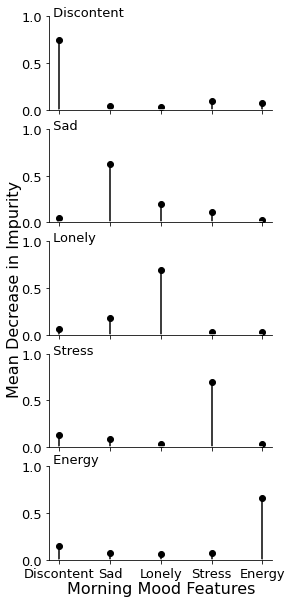

In [100]:
opt_params = {"n_estimators":20,"max_depth":5,"min_samples_split":3}
mood_importance = get_feature_importances(data.mood_only,opt_params,features=["discontent_m","sad_m","lonely_m","stress_m","energy_m"],save=False)

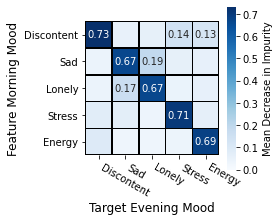

In [121]:
fig, ax = plt.subplots(figsize=(3,3))
df_to_plot = mood_importance.set_index("mood")
sns.heatmap(df_to_plot.T,square=True,cmap="Blues",vmin=0,vmax=df_to_plot.max().max(),
            cbar_kws={"label":"Mean Decrease in Impurity"},ax=ax)
sns.heatmap(df_to_plot.T,mask=df_to_plot.T<0.1,square=True,vmin=0,vmax=df_to_plot.max().max(),cbar=False,annot=True,
            cmap="Blues",lw=0.5,linecolor="black",ax=ax)
# x-axis
xlabels = []
for mood in df_to_plot.index:
    xlabels.append(mood.title())
ax.set_xticklabels(xlabels,fontsize=10,rotation=-30,ha="left")
ax.set_xlabel("Target Evening Mood",fontsize=12)
# y-axis
ylabels = []
for col in df_to_plot.columns:
    ylabels.append(visualize.get_label(col))
ax.set_yticklabels(ylabels,fontsize=10)
ax.set_ylabel("Feature Morning Mood",fontsize=12)
# remainder

plt.savefig("../reports/figures/ema_fitbit/feature_importance-mood_on_mood-heatmap-ux_s20.pdf",bbox_inches="tight")
plt.show()
plt.close()

---

<a id='classification'></a>

[Back to ToC](#toc)
# Classification

In [51]:
from sklearn.model_selection import train_test_split, GridSearchCV

# Random Forest
from sklearn.ensemble import RandomForestClassifier
# Bernoulli Naive Bayes
from sklearn.naive_bayes import GaussianNB
# KNN
from sklearn.neighbors import KNeighborsClassifier
# Support Vector
from sklearn.svm import SVC
# Gradient Boost
from sklearn.ensemble import GradientBoostingClassifier
# Logistic Regressions
from sklearn.linear_model import LogisticRegression

## Selecting Feature Values and Targets

In [83]:
modeling = mood_prediction.Model()

## Option to Binarize
In addition to multiclass prediction, we want to have the option to predict binary targets.

The binary classification should not necessarily be based on low (0 and 1) and high (2 and 3) scores, but rather by taking a closer look at the available data. For instance, since the lonely and sadness scores are so heavily skewed towards  "Not at all" we should consider 1, 2, and 3 as "high" scores since they are uncommon. Or rather we can look at it as "not lonely" and "lonely" which is true even if the response is not strong. 

In [84]:
data_bi = modeling.binarize_mood(data.mood_only,binarize_features=False)

## Comparing and Tuning Models
We test a slew of classification schemes to get the best model

### Defining Models and Hyperparameters to Tune
We use some common classifiers to predict the mood scores that should work for multi-class and binary outcomes.

In [55]:
model_params = {
    "random_forest": {
        "model":RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators":[10,50,100],
            "max_depth":[1,2,3,4,5],
            "min_samples_split":[2,4],
            "min_samples_leaf":[1,2],
        }
    },
    "naive_bayes": {
        "model":GaussianNB(),
        "params": {
            
        }
    },
    "k-nearest_neighbor": {
        "model":KNeighborsClassifier(),
        "params": {
            "n_neighbors":[3,5,7],
            "weights":["uniform","distance"],
            "metric":["euclidean","manhattan","minkowski","jaccard","matching"],
            "p":[1,2],
        }
    },
    "svc": {
        "model": SVC(),
        "params": {
            "kernel":["linear","poly","sigmoid","rbf"],
        }
    },
    "gradientboost":{
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "n_estimators":[10,50,100],
            "max_depth":[1,2,3,4,5],
            "min_samples_split":[2,4],
            "min_samples_leaf":[1,2],
        }
    },
    "logistic_regression": {
        "model":LogisticRegression(random_state=42,max_iter=500),
        "params": {
            "fit_intercept":[True,False],
            "solver":["lbfgs","liblinear"],
        }
    },
}

### Grid Search
Using our favorite, we examine the scores for using these models using 5-fold cross-validation

In [56]:
def optimize_models(df,params,moods=["content","stress","lonely","sad","energy"]):
    """
    Runs GridSearch to determine the best hyperparameters for the given models
    
    Parameters
    ----------
    df : DataFrame
        data with columns for each mood
    params : dict
        ML models and the parameters that we wish to tune
    moods : list-like of default ["content","stress","lonely","sad","energy"]
        moods to consider for the cross-validation - must be column(s) in df
    
    Returns
    -------
    <results> : DataFrame
        
    """
    scores = []
    for mood in moods:
        for model_name, mp in params.items():
            s = datetime.now()
            print(f"\t{model_name.replace('_',' ').title()}")
            clf = GridSearchCV(mp["model"],mp["params"],cv=5,return_train_score=False)
            X, y, _ = get_x_and_y(df,mood=mood)
            clf.fit(X, y)
            scores.append({
                "mood":mood,
                "model":model_name,
                "best_score":clf.best_score_*100,
                "best_params":clf.best_params_
            })
            print("\t\tElapsed Time:\t", datetime.now() - s)
            print(f"\t\tBest Score:\t{round(clf.best_score_*100,1)}\n\t\tBest Params:\t{clf.best_params_}")

    return pd.DataFrame(scores,columns=["mood","model","best_score","best_params"])

### Results from Model Comparison

#### Multi-Class Classification

In [18]:
#opt_res = optimize_models(data,model_params)

The table below highlights the results from running the tests on all moods.

| Mood    | Naive | Random Forest | Naive Bayes | KNN  | SVC  | Gradient | Logistic Regression |
|---------|-------|---------------|-------------|------|------|----------|---------------------|
| Content | 67.3  | 67.1          | 56.6        | 63.3 | 67.4 | 67.5     | 67.3                |
| Stress  | 68.0  | 66.7          | 62.2        | 64.2 | 68.0 | 68.3     | 65.7                |
| Lonely  | 78.8  | 78.4          | 75.2        | 75.1 | 78.5 | 78.7     | 76.8                |
| Sad     | 79.5  | 78.9          | 76.4        | 78.2 | 78.3 | 79.2     | 78.2                |
| Energy  | 56.4  | 55.4          | 45.1        | 49.0 | 55.6 | 56.7     | 52.4                |

<div class="alert alert-block alert-info">
    
From this analysis, the models that we should consider are:
    
* Logistic Regression
* Support Vector
* Gradient Boost 
    
These models were the best-performing and operate on different principles which increases the diversity and strength of our results.
    
</div>

In [61]:
tuned_models = {"lr":LogisticRegression(random_state=42,fit_intercept=True,solver="lbfgs"),
                "svc":SVC(probability=True,kernel="rbf"),
                "grad":GradientBoostingClassifier(random_state=42,n_estimators=100,max_depth=1,min_samples_leaf=2,min_samples_split=2)}

#### Binary Classsification


In [20]:
#opt_res_binary = optimize_models(data_bi,model_params)

In [22]:
#opt_res_binary[opt_res_binary["model"].isin(["logistic_regression","svc","gradientboost"])]

| Mood    | Naive | Random Forest | Naive Bayes | KNN  | SVC  | Gradient | Logistic Regression |
|---------|-------|---------------|-------------|------|------|----------|---------------------|
| Content | 69.5  | 81.0          | 79.2        | 78.2 | 81.0 | 81.0     | 81.0                |
| Stress  | 58.5  | 81.6          | 78.5        | 78.8 | 81.6 | 81.6     | 81.0                |
| Lonely  | 64.3  | 84.6          | 82.2        | 81.1 | 84.6 | 84.6     | 84.6                |
| Sad     | 66.9  | 83.8          | 82.2        | 81.1 | 83.9 | 83.9     | 83.5                |
| Energy  | 71.5  | 75.5          | 75.2        | 73.2 | 75.3 | 75.5     | 75.1                |

<div class="alert alert-block alert-info">
    
From this analysis, we consider the same models as before despite random forest performing equally as well:
    
* Logistic Regression
* Support Vector
* Gradient Boost
    
</div>

In [60]:
tuned_models_bi = {"lr":LogisticRegression(random_state=42,fit_intercept=True,solver="lbfgs"),
                "svc":SVC(probability=True,kernel="linear"),
                "grad":GradientBoostingClassifier(random_state=42,n_estimators=10,max_depth=1,min_samples_leaf=1,min_samples_split=2)}

## Cross-Validation
We will use three different techniques of cross-validation to compare and understand the sensitivity of our models to different sets of the data:
1. **Stratified K-Fold**: This method will ensure that the same ratio of the target classes are preserved which is important especially considering we have four classes in this instance compared to our binary evaluations in the past.
2. **Group K-Fold**: This method will help test the sensitivity to any particular participant groups.
3. **Leave One Group Out**: The most extreme method to understand the sensitivity of the model to a particular participant.

In [24]:
from sklearn.model_selection import StratifiedKFold, GroupKFold, LeaveOneGroupOut, cross_val_score

In [25]:
def cross_validate(df,models,cv_label="skf",moods=["content","stress","lonely","sad","energy"],n_splits=5,verbose=False):
    """
    Runs various cross-validation techniques on the provided models
    
    Parameters
    ----------
    df : DataFrame
    models : dict
        sklearn ML models to consider with keys corresponding to the string of the model name and the keys of the sklearn
        model with provided hyperparameters
    cv_label : {"skf","gkf","logo"}, default "skf"
        Specifies the type of cross-validation technique:
        "skf":stratified k-fold, "gkf":group k-fold, "logo":leave one group out
    moods : list-like of default ["content","stress","lonely","sad","energy"]
        moods to consider for the cross-validation - must be column(s) in df
    n_splits : int, default 5
        number of splits to perform for k-fold cross-validation techniques
    verbose : boolean, default False
        verbose mode for debugging primarily leave one group out cross-validation
    
    Returns
    -------
    <results> : DataFrame
        Cross-validation scores from each split and the average per each mood and model
    """
    if cv_label == "skf":
        cv = StratifiedKFold(n_splits=n_splits)
        groups = None # for consistency
        res = {key: [] for key in ["mood","model"] + [f"split_{i+1}" for i in range(n_splits)] + ["mean"]}
    elif cv_label == "gkf":
        cv = GroupKFold(n_splits=n_splits)
        res = {key: [] for key in ["mood","model"] + [f"split_{i+1}" for i in range(n_splits)] + ["mean"]}
    elif cv_label == "logo":
        cv = LeaveOneGroupOut()
        X,y,groups = get_x_and_y(df)
        if verbose:
            for train_index, test_index in cv.split(X, y, groups):
                print("TRAIN:", train_index, "TEST:", test_index)
                X_train, X_test = groups.iloc[train_index], groups.iloc[test_index]
                print(X_train, X_test)
        res = {key: [] for key in ["mood","model"] + [f"{pt} ({n})" for pt, n in zip(groups.unique(),groups.value_counts().sort_index())] + ["mean"]}
    else:
        raise NameError(f"{cv_label} is an invalid option - choose one of ['skf','gkf','logo']")
        
    for mood in moods:
        for model in tuned_models.keys():
            X, y, groups = get_x_and_y(df,mood=mood)
            clf = tuned_models[model]
            scores = cross_val_score(clf, X, y, cv=cv, groups=groups)
            values = [mood,model]+list(scores)+[np.mean(scores)]
            for key, value in zip(res.keys(),values):
                res[key].append(value)
                
    return pd.DataFrame(data=res)

### Results: Stratified K-Fold

In [87]:
#res_skf = cross_validate(data,tuned_models,cv_label="skf")
#res_skf

<div class="alert alert-block alert-success">
    
Models tend to be rather consistent amongst the various splits - varying by ~0.5 at the most.
    
</div>

### Group K-Fold

In [88]:
#res_gkf = cross_validate(data,tuned_models,cv_label="gkf")
#res_gkf

<div class="alert alert-block alert-success">
    
Similar results to the stratified split both in terms of variation and average scores.
    
</div>

In [28]:
#res_logo = cross_validate(data,tuned_models,cv_label="logo")
#res_logo

<div class="alert alert-block alert-warning">
    
The scores vary widely most likely influenced by the number of datapoints that each participant provides. If those values are low, then the results could either be very _low_ indicating dramatically different responses are very _high_ indicating the same response. Further scrutiny is warranted and condcuted in the [Inspection](#inspection) section.
    
</div>

[Back to Classification](#classification)

---

<a id='prediction'></a>

[Back to ToC](#toc)
# Prediction
Since our models seemed to pass the test with the cross-validation, now we can use them to predict the outcomes. 

In [85]:
predictor = mood_prediction.Prediction()

# Evaluation
[Here](https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd) is a nice article regarding various metrics to consider.

In [86]:
evaluator = mood_prediction.Evaluation()

## Confusion Matrices
We can look at how well our models perform by considering the confusion matrices.

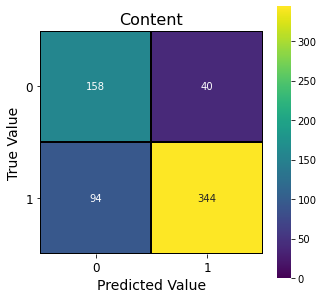

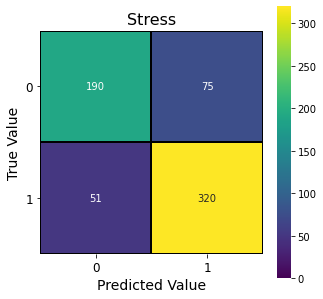

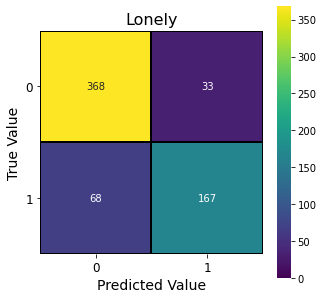

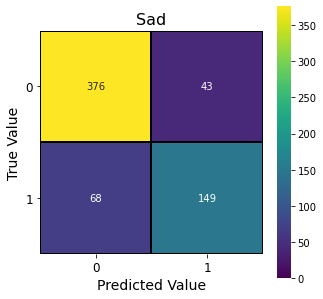

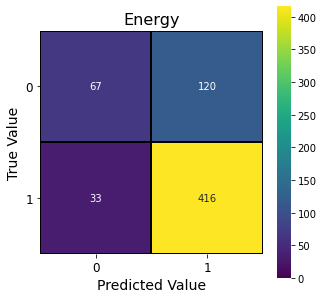

In [87]:
for mood in ["content","stress","lonely","sad","energy"]:
    y_true, y_pred = predictor.get_predictions(data_bi,mood,tuned_models["grad"],include_evening=False)
    _ = evaluator.get_cm(y_true, y_pred, plot=True,title=mood.title())

### Defining the Confusion Matrix
* **Positive Classes**: 2 and 3
* **Negative Classes**: 0 and 1

## All the metrics
Who knew there was a fancy function for all this? In addition, we borrow some advice from the TDS crew.

### Multiclass

In [92]:
scores_multi = evaluator.get_scoring_metrics(data.mood_only,tuned_models["grad"],binary=False,include_evening=False)

In [93]:
print(scores_multi.round(decimals=2).set_index("mood").to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  accuracy &  precision &  recall &    f1 \\
mood       &           &            &         &       \\
\midrule
Discontent &      0.57 &       0.69 &    0.67 &  0.67 \\
Stress     &      0.63 &       0.69 &    0.68 &  0.68 \\
Lonely     &      0.56 &       0.77 &    0.78 &  0.77 \\
Sad        &      0.55 &       0.78 &    0.79 &  0.78 \\
Energy     &      0.50 &       0.55 &    0.57 &  0.55 \\
\bottomrule
\end{tabular}



### Binary

In [94]:
scores_bi = evaluator.get_scoring_metrics(data_bi,tuned_models_bi["grad"],binary=True,include_evening=False)

In [95]:
print(scores_bi.round(decimals=2).set_index("mood").to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  accuracy &  precision &  recall &    f1 \\
mood       &           &            &         &       \\
\midrule
Discontent &      0.82 &       0.88 &    0.95 &  0.91 \\
Stress     &      0.81 &       0.83 &    0.88 &  0.85 \\
Lonely     &      0.83 &       0.83 &    0.74 &  0.78 \\
Sad        &      0.81 &       0.79 &    0.72 &  0.75 \\
Energy     &      0.50 &       0.72 &    1.00 &  0.84 \\
\bottomrule
\end{tabular}



[Back to Prediction](#prediction)

---

[Back to ToC](#toc)
# Saving
Saving the results in addition to the data files that were used to generate those results.

## Data Files
We have four data files to save for later use.

## Results

In [118]:
with pd.ExcelWriter('../data/interim/mood_prediction/results-mood_on_mood.xlsx') as writer:  
    for model,model_bi in zip(tuned_models.keys(),tuned_models_bi.keys()):
        for include_evening in [False,True]:
            print(f"{model.upper()} - Include Evening: {include_evening}")
            print("\tMulticlass")
            res = get_scoring_metrics(data,tuned_models[model],include_evening=include_evening)
            res.to_excel(writer, sheet_name=f"{model}-multiclass-evening_{str(include_evening).lower()}")
            print("\tBinary")
            res_bi = get_scoring_metrics(data_bi,tuned_models_bi[model_bi],binary=True,include_evening=include_evening)
            res_bi.to_excel(writer, sheet_name=f"{model}-binary-evening_{str(include_evening).lower()}")

LR - Include Evening: False
	Multiclass
	Binary
LR - Include Evening: True
	Multiclass
	Binary
SVC - Include Evening: False
	Multiclass
	Binary
SVC - Include Evening: True
	Multiclass
	Binary
GRAD - Include Evening: False
	Multiclass
	Binary
GRAD - Include Evening: True
	Multiclass
	Binary


[Back to Saving](#saving)

---

[Back to Top](#top)